# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [2]:
DATA_FOLDER = '../../ADA2017-Tutorials/02 - Intro to Pandas/Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

In [305]:
# config
%matplotlib inline

# imports
import pandas as pd
import numpy as np
import glob
from datetime import datetime
import calendar
import re

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [68]:
# Write your answer here

## Methodology

We start by manually browsing through the data to get an understanding of the contents and identify the variables of interest. We quickly realize that there are naming inconsistencies, formatting issues, as well as missing and potentially invalid values.

We opt to use cumulative values instead of daily values for two reasons:
1. As opposed to daily values, cumulative totals are present in all three datasets.
2. Cumulative values are more tolerant of missing values, since they cumulate all previous days.
3. It seems easier to correct invalid cumulative values because they are supposed to be monotonic increasing 

We parse in all the CSV files per country (using `pandas.read_csv`) and concatenate them together into a single frame. We perform cleanup on a per-country basis as the CSV labels are different across countries and each country requires slightly different cleanup rules, which describe below. The cleanup phase also extracts the relevant data and produces standardized dataframes with the following structure: $(date, value)$. We collect two such dataframes per country: one for the new reported cases and one for the deaths.

After collecting cumulative series, we need to clean up the data and convert the results into daily values in order to compute the requested averages.

We clean up a cumulative series using the utility function `clean_frame` below. This function computes a range of valid values using the min and max values, excludes values that fall outside this range, and then drops all values which do not increase monotonically. Once we have a clean cumulative series, we compute the corresponding daily series using the `cum_to_daily` function, which simply subtracts consecutive values in the series (we transpose the frame with `T` and then use `diff`).

In [256]:
# Utility functions

def clean_frame(df):
    # Drop values which are not in the interval between first and last values
    minv = df.value[0]
    maxv = df.value[-1]
    df = df.query('value >= %d and value <= %d' % (minv, maxv)).copy()

    # Drop values which do not fit the monotonic criteria
    i = 0
    for index, row in df.iterrows():
        if i <= row.value:
            i = row.value
        else:
            df.drop(index, inplace=True)
    
    # Let's make sure it's monotonic now
    assert((df['value'].T.diff().fillna(0) >= 0).all())
    return df

def cum_to_daily(df):
    df = df.copy()
    df = df.value.set_value(min(df.index) - pd.DateOffset(1), 0).sort_index() # prepend a 0 to capture the first daily value
    return df.T.diff()[1:]

def country_frame(df1, df2, country):
    merged = df1.merge(df2, how='outer', left_index=True, right_index=True).fillna(0)
    merged['country'] = country
    return merged.set_index(['country'], append=True).swaplevel()

Guinea CSVs appear to be the cleanest input files and have consistent naming (at least for the values we are interested in). Formatting-wise, the main issue is the storing of values as `string`s, which we converted to numeric values using `pandas.to_numeric`.

In [426]:
# Read in Guinea CSV
guinea_df = pd.concat((pd.read_csv(f, usecols=['Date', 'Description', 'Totals'], parse_dates=['Date']) 
                       for f in glob.glob(DATA_FOLDER+'/ebola/guinea_data/*.csv')))
guinea_df.columns = ['date', 'key', 'value']
guinea_df[['value']] = guinea_df[['value']].apply(pd.to_numeric, errors='coerce')

# Collect new cases
guinea_cases = guinea_df.loc[guinea_df.key == 'Cumulative (confirmed + probable + suspects)'][['date', 'value']].set_index('date').sort_index()

# Collect deaths
guinea_deaths = guinea_df.loc[guinea_df.key == 'Total deaths (confirmed + probables + suspects)'][['date', 'value']].set_index('date').sort_index()

# Clean up the two frames
guinea_cases_cum = clean_frame(guinea_cases)
guinea_deaths_cum = clean_frame(guinea_deaths)

# Convert to daily
guinea_cases_daily = cum_to_daily(guinea_cases).to_frame('cases')
guinea_deaths_daily =  cum_to_daily(guinea_deaths).to_frame('deaths')

# Combine the two into a single frame
guinea = country_frame(guinea_cases_daily, guinea_deaths_daily, 'Guinea')

Liberia CSVs are a little more trickier.
* First, in terms of formatting, the same variable name can appear in multiple variants, sometimes with new lines in the name. We use a simple regular expression to capture the different cases.
* Second, in terms of content, we observed that there are many blanks, so looking at a single variable for the total number of cases and deaths is not good enough. Instead, we look at both the aggregate (probable + suspected + confirmed) and the individual values: we collect both and if they do not match or some values are missing, wecombine them into a final value per date using the maximum of the two. The choice of `max()` is arbitrary, and may lead to a pessimistic estimate.

In [254]:
# Read in Liberia CSV
liberia_df = pd.concat((pd.read_csv(f, usecols=['Date', 'Variable', 'National'], parse_dates=['Date'])
                        for f in glob.glob(DATA_FOLDER+'/ebola/liberia_data/*.csv')))
liberia_df.columns = ['date', 'key', 'value']

# Collect new cases
df = liberia_df.copy()
df1 = df.loc[df.key.str.match('.*Cumulative.*confirmed.*probable.*suspected.*', flags=re.DOTALL)][['date', 'value']].set_index('date')
df2 = df.loc[df.key.isin(['Total suspected cases', 'Total probable cases', 'Total confirmed cases'])].groupby('date').sum()
liberia_cases = pd.concat([df1, df2]).sort_index().groupby('date').max().dropna()

# Collect deaths
df1 = df.loc[df.key.str.match('.*Total.*death.*confirmed.*probable.*suspected.*', flags=re.DOTALL)][['date', 'value']].set_index('date')
df2 = df.loc[df.key.isin(['Total death/s in suspected cases', 'Total death/s in probable cases', 'Total death/s in confirmed cases'])].groupby('date').sum()
liberia_deaths = pd.concat([df1, df2]).sort_index().groupby('date').max().dropna()

# Clean up the two frames
liberia_cases_cum = clean_frame(liberia_cases)
liberia_deaths_cum = clean_frame(liberia_deaths)

# Convert to daily
liberia_cases_daily = cum_to_daily(liberia_cases).to_frame('cases')
liberia_deaths_daily =  cum_to_daily(liberia_deaths).to_frame('deaths')

# Combine the two into a single frame
liberia = country_frame(liberia_cases_daily, liberia_deaths_daily, 'Liberia')

Sierra Leone CSVs require a bit more processing.
* Formatting-wise, there are no surprises, other than the fact that some values as stored as `string`s, which we convert to numeric values as we did in the Guinea case.
* Content-wise, however, there are some missing totals while the results for individual regions (columns other than `National`) are available. As a result, we opted to collect both the national totals and the sum of the individual regions, and to combine them by taking the maximum of both. As in the Liberia case, taking the maximum is an arbitrary choice and we could have opted to combine them differently instead (e.g., `min`, `average`).

In [253]:
# Read in Sierra Leone CSV
# Note: unlike the other two countries, we read all columns because we need to sum them up to fill in missing data
sl_df = pd.concat((pd.read_csv(f, parse_dates=['date']) for f in glob.glob(DATA_FOLDER+'/ebola/sl_data/*.csv')))

# Collect cases
df1 = sl_df[['date', 'variable', 'National']].copy().set_index('date')
df1 = df1.loc[df1['variable'].isin(['cum_suspected', 'cum_probable', 'cum_confirmed'])][['National']].apply(pd.to_numeric, errors='coerce').groupby('date').sum()
df1.columns = ['value']

df2 = sl_df.copy().set_index('date')
df2 = df2.loc[df2['variable'].isin(['cum_suspected', 'cum_probable', 'cum_confirmed'])]
df2 = df2.loc[:, ~df2.columns.isin(['variable', 'National'])].fillna(0).apply(pd.to_numeric, errors='coerce')
df2 = df2.groupby('date').sum()
df2 = df2.sum(axis=1).to_frame('value')

sl_cases = pd.concat([df1, df2]).sort_index().groupby('date').max().dropna()
sl_cases

# Collect deaths
df1 = sl_df[['date', 'variable', 'National']].copy().set_index('date')
df1 = df1.loc[df1['variable'].isin(['death_suspected', 'death_probable', 'death_confirmed'])][['National']].apply(pd.to_numeric, errors='coerce').groupby('date').sum()
df1.columns = ['value']

df2 = sl_df.copy().set_index('date')
df2 = df2.loc[df2['variable'].isin(['death_suspected', 'death_probable', 'death_confirmed'])]
df2 = df2.loc[:, ~df2.columns.isin(['variable', 'National'])].dropna().apply(pd.to_numeric, errors='coerce')
df2 = df2.groupby('date').sum()
df2 = df2.sum(axis=1).to_frame('value')

sl_deaths = pd.concat([df1, df2]).sort_index().groupby('date').max().dropna()

# Clean up the two frames
sl_cases_cum = clean_frame(sl_cases)
sl_deaths_cum = clean_frame(sl_deaths)

# Convert to daily
sl_cases_daily = cum_to_daily(sl_cases).to_frame('cases')
sl_deaths_daily =  cum_to_daily(sl_deaths).to_frame('deaths')

# Combine the two into a single frame
sl = country_frame(sl_cases_daily, sl_deaths_daily, 'Sierra Leone')

Now that we have all three dataframes in a clean and structured format, we simply combine them into a single frame named `ebola`. Using that dataframe, we compute the daily averages per month as follows:
1. Compute monthly totals, i.e. sum up all values for both new cases and deaths per month.
2. Compute daily averages from there, i.e. divide the monthly totals by the corresponding number of days.

The final result is presented in the `ebola_daily_averages` dataframe.

In [369]:
# Combine all 3 frames
ebola = pd.concat([guinea, liberia, sl])

# Compute monthly totals
ebola_month_totals = ebola.reset_index().assign(year=lambda x: x['date'].dt.year, month=lambda x: x['date'].dt.month).groupby(by=['country', 'year', 'month']).sum()

# Create daily averages per month
ebola_daily_averages = ebola_month_totals.copy()
ebola_daily_averages['cases'] = ebola_daily_averages['cases'] / ebola_daily_averages.index.map(lambda x: calendar.monthrange(x[1], x[2])[1])
ebola_daily_averages['deaths'] = ebola_daily_averages['deaths'] / ebola_daily_averages.index.map(lambda x: calendar.monthrange(x[1], x[2])[1])

# We are done! ebola_daily_averages contains the requested info

# Prettifying months (month name instead of number)
ebola_daily_averages = ebola_daily_averages.reset_index()
ebola_daily_averages['month'] = ebola_daily_averages['month'].map(lambda x: calendar.month_name[x])
ebola_daily_averages = ebola_daily_averages.set_index(['country', 'year', 'month'])
ebola_daily_averages

cases     deaths
country      year month                          
Guinea       2014 August     24.161290  15.774194
                  September  14.000000   7.500000
                  October     0.967742   0.806452
Liberia      2014 June        3.000000   1.633333
                  July        7.000000   3.096774
                  August     41.129032  23.870968
                  September  74.800000  39.100000
                  October    87.064516  20.612903
                  November   37.600000  15.333333
                  December    4.645161   4.290323
Sierra Leone 2014 August     38.387097  14.032258
                  September  41.733333   5.433333
                  October    69.967742  27.000000
                  November   83.266667  14.233333
                  December   37.548387   6.838710

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [57]:
# Write your answer here

## Methodology

Looking at the files with little understanding of RNA seequencing, it appears that the 9 spreadsheets contain tuples of the form $(taxonomy, value)$ while the metadata contains tuples of $(barcode, group, sample)$. It appears the $barcode$ corresponds to the name of a spreadsheet.

We therefore assume that the final output frame should contain tuples of the form $(barcode, group, sample, taxonomy, value)$ where $barcode$ is joined with the data contained in the corresponding spreadsheet. It appears natural to index the data using the following multi-index: $(barcode, group, sample, taxonomy)$.

In [422]:
# Read each spreadsheet into a dataframe and append a column for the barcode
mid = []
for i in range(1,10):
    m = pd.read_excel(DATA_FOLDER+'/microbiome/MID%d.xls' % i, names=['taxon', 'value'], sheetname='Sheet 1', header=None)
    m['barcode'] = 'MID%d' % i
    mid.append(m)

# Put all spreadsheets into a single dataframe
df = pd.concat(mid)

# Read metadata
meta = pd.read_excel(DATA_FOLDER+'/microbiome/metadata.xls', sheetname='Sheet1')
meta.columns = map(str.lower, meta.columns) # clean up column names

# Merge with metadata (will join on barcode)
mb = pd.merge(df, meta)

# Replace NaNs with unknown and set index
mb[['sample']] = mb[['sample']].replace(np.nan, 'unknown')
mb = mb.set_index(['barcode', 'group', 'sample', 'taxon'])

# Make sure we have a unique index and no NaNs
assert(mb.index.is_unique)
assert(len(mb[mb.isnull().any(axis=1)]) == 0)

# Here goes the microbiome dataframe
mb

value
barcode group              sample  taxon                                                    
MID1    EXTRACTION CONTROL unknown Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      7
                                   Archaea "Crenarchaeota" Thermoprotei Desulfuroc...      2
                                   Archaea "Crenarchaeota" Thermoprotei Sulfolobal...      3
                                   Archaea "Crenarchaeota" Thermoprotei Thermoprot...      3
                                   Archaea "Euryarchaeota" "Methanomicrobia" Metha...      7
                                   Archaea "Euryarchaeota" "Methanomicrobia" Metha...      1
                                   Archaea "Euryarchaeota" "Methanomicrobia" Metha...      1
                                   Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...      1
                                   Archaea "Euryarchaeota" Archaeoglobi Archaeoglo...      1
                                   Archaea "Euryarchaeota" Halobacteria Halobacter...      1
                                   Archaea "Euryarchaeota" Halobacteria Halobacter...      4
                                   Archaea "Euryarchaeota" Halobacteria Halobacter...      1
                                   Archaea "Euryarchaeota" Halobacteria Halobacter...      2
                                   Archaea "Euryarchaeota" Halobacteria Halobacter...      4
                                   Archaea "Euryarchaeota" Methanococci Methanococ...      1
                                   Archaea "Euryarchaeota" Methanopyri Methanopyra...     12
                                   Archaea "Euryarchaeota" Thermoplasmata Thermopl...      2
                                   Bacteria "Actinobacteria" Actinobacteria Actino...      2
                                   Bacteria "Actinobacteria" Actinobacteria Actino...      1
                                   Bacteria "Actinobacteria" Actinobacteria Actino...      1
                                   Bacteria "Actinobacteria" Actinobacteria Actino...      1
                                   Bacteria "Actinobacteria" Actinobacteria Actino...      2
                                   Bacteria "Actinobacteria" Actinobacteria Actino...     53
                                   Bacteria "Actinobacteria" Actinobacteria Actino...      1
                                   Bacteria "Actinobacteria" Actinobacteria Actino...      2
                                   Bacteria "Actinobacteria" Actinobacteria Actino...      3
                                   Bacteria "Actinobacteria" Actinobacteria Actino...      1
                                   Bacteria "Actinobacteria" Actinobacteria Actino...     99
                                   Bacteria "Actinobacteria" Actinobacteria Actino...     17
                                   Bacteria "Actinobacteria" Actinobacteria Actino...      2
...                                                                                      ...
MID9    Control 2          stool   Bacteria "Proteobacteria" Gammaproteobacteria O...     10
                                   Bacteria "Proteobacteria" Gammaproteobacteria O...      1
                                   Bacteria "Proteobacteria" Gammaproteobacteria O...      1
                                   Bacteria "Proteobacteria" Gammaproteobacteria P...      1
                                   Bacteria "Proteobacteria" Gammaproteobacteria P...     12
                                   Bacteria "Proteobacteria" Gammaproteobacteria P...      4
                                   Bacteria "Proteobacteria" Gammaproteobacteria P...    805
                                   Bacteria "Proteobacteria" Gammaproteobacteria P...    862
                                   Bacteria "Proteobacteria" Gammaproteobacteria P...     12
                                   Bacteria "Proteobacteria" Gammaproteobacteria P...   3534
                                   Bacteria "Proteobacteria" Gammaproteobacteria T...   

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [58]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [59]:
# Write your answer here

In [433]:
df = pd.read_excel(DATA_FOLDER+'/titanic.xls')
df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


## 1. Describe the type and the value range of each attribute. Indicate and transform the attributes that can be `Categorical`.

* `pclass`: 
* `survived`: 
* `name`: 
* `sex`: 
* `age`: 
* `sibsp`: 
* `parch`: 
* `ticket`: 
* `fare`: 
* `cabin`: 
* `embarked`: 
* `boat`: 
* `body`: 
* `home.dest`: 

## 2. Plot histograms for the travel class, embarkation port, sex and age attributes. For the latter one, use _discrete decade intervals_. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1161409e8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x115f73ef0>], dtype=object)

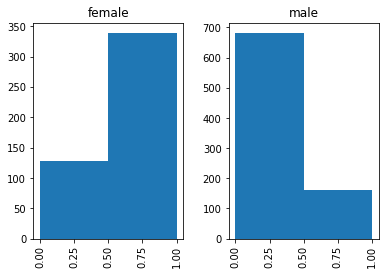

In [430]:
df.hist(column='survived', grid=True, bins=2, by='sex')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116f29320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11690f3c8>]], dtype=object)

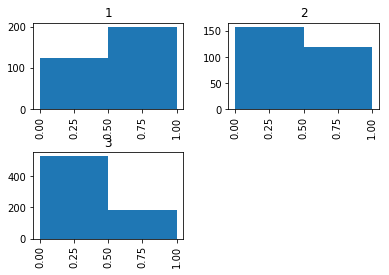

In [431]:
df.hist(column='survived', grid=True, by='pclass', bins=2)

## 3. Calculate the proportion of passengers by _cabin floor_. Present your results in a _pie chart_.

## 4. For each _travel class_, calculate the proportion of the passengers that survived. Present your results in _pie charts_.

## 5. Calculate the proportion of the passengers that survived by _travel class_ and _sex_. Present your results in a _single histogram_.

## 6. Create 2 equally populated _age categories_ and calculate survival proportions by _age category_, _travel class_ and _sex_. Present your results in a `DataFrame` with unique index.